## Accessing Sentinel-1 RTC data with the Planetary Computer STAC API

The [Sentinel 1 RTC](https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc) product in this collection is a radiometrically terrain corrected product derived from the [Sentinel-1 Ground Range Detected (GRD)](https://planetarycomputer.microsoft.com/dataset/sentinel-1-grd) Level-1 products produced by the European Space Agency.

### Environment setup

Running this notebook requires an API key.

* The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.
* To use your API key locally, set the environment variable `PC_SDK_SUBSCRIPTION_KEY` or use `planetary_computer.settings.set_subscription_key(<YOUR API Key>)`

See [when an account is needed](https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed) for more, and [request an account](http://planetarycomputer.microsoft.com/account/request) if needed.

In [1]:
import ipyleaflet
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pystac
import pystac_client
import planetary_computer
import requests
import rich.table
import pandas as pd


from IPython.display import Image

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Choose an area and time of interest

We'll search for assets acquired over Panama in the first week of May, 2022. You can use the [Planetary Computer Explorer](https://planetarycomputer.microsoft.com/explore?c=-79.6735%2C9.0461&z=9.91&ae=0&v=2&d=sentinel-1-rtc&s=false%3A%3A100%3A%3Atrue&m=Most+recent+-+VV%2C+VH&r=VV%2C+VH+False-color+composite) to find areas of interest.

In [3]:
#Define bounding box for area of interest
bbox = [149.703, -36.064, 150.716, -35.071]
search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime="2020-02-07/2020-02-11",
)

In [4]:


# Create a DataFrame with a 'SolarDay' column
data = {'Timestamp': ['2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11']}
df = pd.DataFrame(data)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['SolarDay'] = df['Timestamp'].dt.dayofyear

grouped=df.groupby("SolarDay").max()
    




In [5]:
items = search.item_collection()
print(f"Returned {len(items)} Items")


Returned 2 Items


In [6]:
items


id: S1A_IW_GRDH_1SDV_20200210T191613_20200210T191638_031194_039640_rtc
"bbox: [148.08047433, -36.89303731, 151.2863385, -34.77242329]"
datetime: 2020-02-10T19:16:26.339845Z
platform: SENTINEL-1A
"s1:shape: [30692, 24615]"
"proj:bbox: [590300.0, 5907470.0, 897220.0, 6153620.0]"
proj:epsg: 32755
"proj:shape: [24615, 30692]"
end_datetime: 2020-02-10 19:16:38.838854+00:00
constellation: Sentinel-1
s1:resolution: high


The `rendered_preview` asset lets us quickly visualize the data. For Seninel-1 RTC, this produces a false-color composite from a combination of the VV and VH bands.

In [7]:
from IPython.display import Image

item = items[0]
Image(url=item.assets["rendered_preview"].href)

### Inspect the STAC metadata

The STAC metadata includes many useful pieces of metadata, including metadata from the [SAR](https://github.com/stac-extensions/sar) and [Satellite](https://github.com/stac-extensions/sat) extensions.

In [8]:
table = rich.table.Table("key", "value")
for k, v in sorted(item.properties.items()):
    table.add_row(k, str(v))

table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                                                       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                                                  │
│ datetime                              │ 2020-02-10T19:16:26.339845Z                                 │
│ end_datetime                          │ 2020-02-10 19:16:38.838854+00:00                            │
│ platform                              │ SENTINEL-1A                                                 │
│ proj:bbox                             │ [590300.0, 5907470.0, 897220.0, 6153620.0]                  │
│ proj:epsg                             │ 32755                                                       │
│ proj:shape                            │ [24615, 30692]                                              │
│ proj:transform                        │ [10.0, 0.0, 590300.0, 0.0, -10.0, 6153620.0, 0.0, 0.0, 1.0] │
│ s1:datatake_id                        │ 235072                                                      │
│ s1:instrument_configuration_ID        │ 6                                                           │
│ s1:orbit_source                       │ RESORB                                                      │
│ s1:processing_level                   │ 1                                                           │
│ s1:product_timeliness                 │ Fast-24h                                                    │
│ s1:resolution                         │ high                                                        │
│ s1:shape                              │ [30692, 24615]                                              │
│ s1:slice_number                       │ 11                                                          │
│ s1:total_slices                       │ 16                                                          │
│ sar:center_frequency                  │ 5.405                                                       │
│ sar:frequency_band                    │ C                                                           │
│ sar:instrument_mode                   │ IW                                                          │
│ sar:looks_azimuth                     │ 1                                                           │
│ sar:looks_equivalent_number           │ 4.4                                                         │
│ sar:looks_range                       │ 5                                                           │
│ sar:observation_direction             │ right                                                       │
│ sar:pixel_spacing_azimuth             │ 10                                                          │
│ sar:pixel_spacing_range               │ 10                                                          │
│ sar:polarizations                     │ ['VV', 'VH']                                                │
│ sar:product_type                      │ GRD                                                         │
│ sar:resolution_azimuth                │ 22                                                          │
│ sar:resolution_range                  │ 20                                                          │
│ sat:absolute_orbit                    │ 31194                                                       │
│ sat:orbit_state                       │ descending                                                  │
│ sat:platform_international_designator │ 2014-016A                                                   │
│ sat:relative_orbit                    │ 147                                                         │
│ start_datetime                        │ 2020-02-10 19:16:13.840836+00:00                            │
└───────────────────────────────────────┴───────

The data assets on every Sentinel-1 RTC item will be some combination of `hh`, `hv`, `vh`, and `vv`. These represent the terrain-corrected gamma nought values of a signal transmitted in one polarization ("h" or "v") and received in another ("h" or "v"). The `sar:polarizations` field indicates which assets are available.

In [9]:
item.properties["sar:polarizations"]

['VV', 'VH']

### Visualize the assets

Next, we'll load the `vv` data into [xarray](https://xarray.pydata.org/) and plot the results. We'll use [Dask](http://dask.org/) to load the data in parallel. We're working with a small amount of data so we'll use a single machine. For larger datasets, see [Scaling with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/).

In [10]:
from distributed import Client

client = Client(processes=False)
print(client.dashboard_link)

/user/jane.kennedy10@uon.edu.au/proxy/40707/status


/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40707 instead
  warnings.warn(


In [11]:
import stackstac
ds = stackstac.stack(items, bounds_latlon=bbox, epsg=32756, resolution=20)
ds

/srv/conda/envs/notebook/lib/python3.11/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-263329290482cd5adcbe82b00874e200' (time: 2,
                                                                band: 2,
                                                                y: 5640, x: 4748)>
dask.array<fetch_raster_window, shape=(2, 2, 5640, 4748), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2020-02-10T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2020...
  * band                                   (band) <U2 'vh' 'vv'
  * x                                      (x) float64 1.993e+05 ... 2.943e+05
  * y                                      (y) float64 6.117e+06 ... 6.004e+06
    sar:looks_equivalent_number            float64 4.4
    ...                                     ...
    s1:product_timeliness                  <U8 'Fast-24h'
    platform                               <U11 'SENTINEL-1A'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            (band) <U173 'Terrain-corrected ga...
    title                                  (band) <U41 'VH: vertical transmit...
    epsg                                   int64 32756
Attributes:
    spec:        RasterSpec(epsg=32756, bounds=(199340, 6003900, 294300, 6116...
    crs:         epsg:32756
    transform:   | 20.00, 0.00, 199340.00|\n| 0.00,-20.00, 6116700.00|\n| 0.0...
    resolution:  20

We'll select the `vv` band for the first timestep found by our search.

In [12]:
vv = ds.sel(band="vv")[0].compute()

In [13]:
vv

<xarray.DataArray 'stackstac-263329290482cd5adcbe82b00874e200' (y: 5640, x: 4748)>
array([[       nan,        nan,        nan, ..., 0.0199072 , 0.02691407,
        0.01979473],
       [       nan,        nan,        nan, ..., 0.04367743, 0.02087177,
        0.0168688 ],
       [       nan,        nan,        nan, ..., 0.02199521, 0.01717359,
        0.02431669],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates: (12/39)
    time                                   datetime64[ns] 2020-02-10T19:16:01...
    id                                     <U66 'S1A_IW_GRDH_1SDV_20200210T19...
    band                                   <U2 'vv'
  * x                                      (x) float64 1.993e+05 ... 2.943e+05
  * y                                      (y) float64 6.117e+06 ... 6.004e+06
    sar:looks_equivalent_number            float64 4.4
    ...                                     ...
    s1:product_timeliness                  <U8 'Fast-24h'
    platform                               <U11 'SENTINEL-1A'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32756
Attributes:
    spec:        RasterSpec(epsg=32756, bounds=(199340, 6003900, 294300, 6116...
    crs:         epsg:32756
    transform:   | 20.00, 0.00, 199340.00|\n| 0.00,-20.00, 6116700.00|\n| 0.0...
    resolution:  20

The distribution of the raw values is quite skewed:

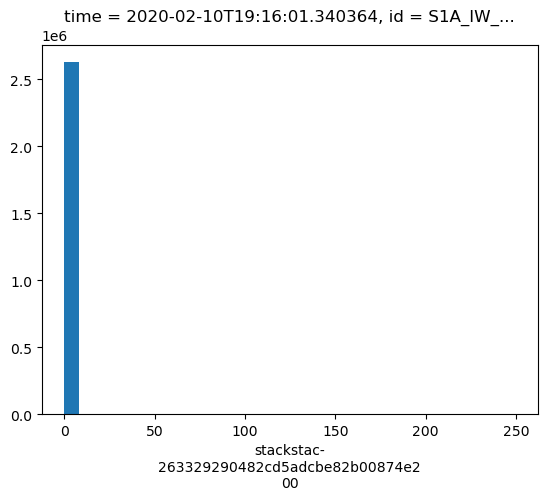

In [14]:
vv.plot.hist(bins=30);

So the values are typically transformed before visualization:

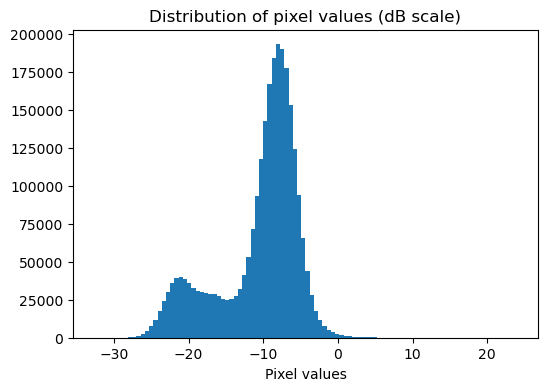

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))

def db_scale(x):
    return 10 * np.log10(x)

db_scale(vv).plot.hist(bins=100, ax=ax)
ax.set(title="Distribution of pixel values (dB scale)", xlabel="Pixel values");

In [16]:
# The below plots well in a single image. (in greyscale) When converted to timeseries the bimodality decreases and the image plots as below 

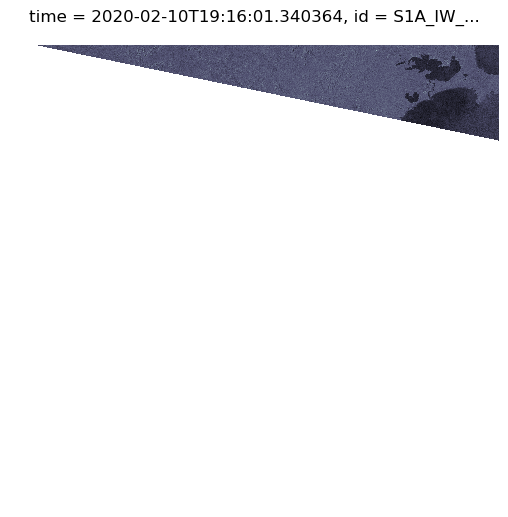

In [17]:
img = (
    db_scale(vv)
    .coarsen(x=1, y=1, boundary="trim")
    .max()
    .plot.imshow(cmap="bone", size=6, aspect=1.05, add_colorbar=False)
)
img.axes.set_axis_off();

### compute datasets, run ostu on time series, get binary outputs

In [18]:
vv_ds = ds.sel(band="vv").compute()

In [19]:
# rescale to decibels (db)
vv_ds_dbscale = db_scale(vv_ds)

In [20]:
from skimage.filters import threshold_otsu

vv_ds_dbscale_list = []

# for timeseries in dataset vv_ds_dbscale
for x in vv_ds_dbscale:
    # get values as np.array (needed for ostu)
    arr = x.values
    # change all nans to 0
    arr = np.nan_to_num(arr, nan=0)
    # get otsu threshold
    # threshold = threshold_otsu(arr)
    threshold = -12
    print(threshold)
    # apply threshold to x
    x_threshold = xr.where(x >= threshold, 1, 0).squeeze()
    # add to list of datasets
    vv_ds_dbscale_list.append(x_threshold)
    # concat all to single dataset (could also do xr.merge but there was some problem with the time dims compatibility
    vv_ds_binary = xr.concat(vv_ds_dbscale_list, dim='time')


-12
-12


In [21]:
arr

array([[ -8.31355662,  -6.6754254 ,  -7.67200567, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.21998577,  -8.21180217,  -7.02329105, ...,   0.        ,
          0.        ,   0.        ],
       [ -8.57690238,  -7.99267929,  -6.45242013, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ -3.36076971, -11.03219431,  -8.48967055, ...,  -8.98055417,
        -12.7831016 ,  -9.60593245],
       [ -7.90127003,  -6.71705021,  -9.53706095, ..., -11.85389768,
        -15.233185  , -13.27255833],
       [ -8.77902797,  -7.47626509,  -8.48538318, ...,  -8.75277475,
        -13.8708317 , -15.24725189]])

In [22]:
vv_ds_binary

<xarray.DataArray 'stackstac-263329290482cd5adcbe82b00874e200' (time: 2,
                                                                y: 5640, x: 4748)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 0, 1],
        [1, 1, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 1, 0, 0]]])
Coordinates: (12/39)
  * time                                   (time) datetime64[ns] 2020-02-10T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2020...
    band                                   <U2 'vv'
  * x                                      (x) float64 1.993e+05 ... 2.943e+05
  * y                                      (y) float64 6.117e+06 ... 6.004e+06
    sar:looks_equivalent_number            float64 4.4
    ...                                     ...
    s1:product_timeliness                  <U8 'Fast-24h'
    platform                               <U11 'SENTINEL-1A'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32756

In [23]:
vv_ds_binary.attrs = ds.attrs

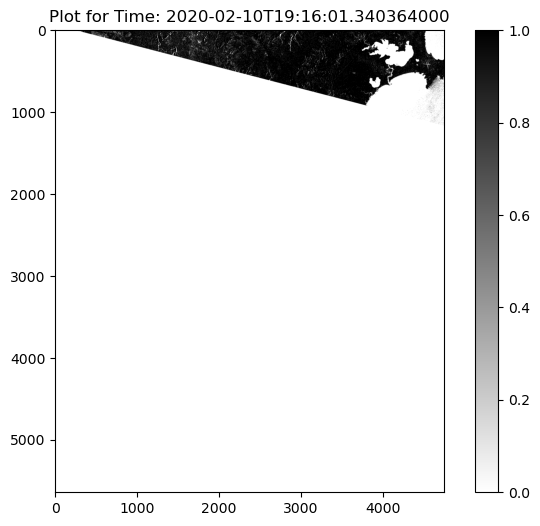

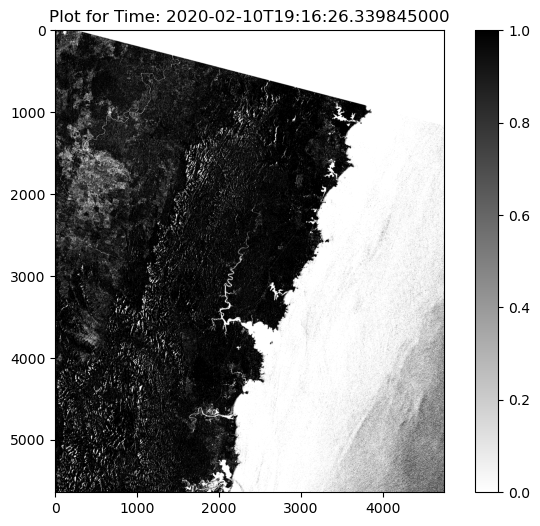

In [24]:
import matplotlib.pyplot as plt

# Iterate over each time slice and create a plot
for i, time_slice in enumerate(vv_ds_binary.time):
    plt.figure(figsize=(8, 6))
    plt.imshow(vv_ds_binary.sel(time=time_slice), cmap='binary')
    plt.title(f'Plot for Time: {time_slice.values}')
    plt.colorbar()
    plt.show()

In [25]:
# calculate average wetness through time
wet_pixels_sum = vv_ds_binary.sum(dim=['time'])
wet_pixels_count = vv_ds_binary.count(dim=['time'])


In [26]:
wet_pixels_sum

<xarray.DataArray 'stackstac-263329290482cd5adcbe82b00874e200' (y: 5640, x: 4748)>
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 0]])
Coordinates: (12/33)
    band                                   <U2 'vv'
  * x                                      (x) float64 1.993e+05 ... 2.943e+05
  * y                                      (y) float64 6.117e+06 ... 6.004e+06
    sar:looks_equivalent_number            float64 4.4
    sar:center_frequency                   float64 5.405
    s1:instrument_configuration_ID         <U1 '6'
    ...                                     ...
    s1:product_timeliness                  <U8 'Fast-24h'
    platform                               <U11 'SENTINEL-1A'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32756

In [27]:
wet_pixels_sum.attrs = ds.attrs

In [28]:
wet_pixels_sum

<xarray.DataArray 'stackstac-263329290482cd5adcbe82b00874e200' (y: 5640, x: 4748)>
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 0]])
Coordinates: (12/33)
    band                                   <U2 'vv'
  * x                                      (x) float64 1.993e+05 ... 2.943e+05
  * y                                      (y) float64 6.117e+06 ... 6.004e+06
    sar:looks_equivalent_number            float64 4.4
    sar:center_frequency                   float64 5.405
    s1:instrument_configuration_ID         <U1 '6'
    ...                                     ...
    s1:product_timeliness                  <U8 'Fast-24h'
    platform                               <U11 'SENTINEL-1A'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32756
Attributes:
    spec:        RasterSpec(epsg=32756, bounds=(199340, 6003900, 294300, 6116...
    crs:         epsg:32756
    transform:   | 20.00, 0.00, 199340.00|\n| 0.00,-20.00, 6116700.00|\n| 0.0...
    resolution:  20

In [29]:
wet_pixels_count

<xarray.DataArray 'stackstac-263329290482cd5adcbe82b00874e200' (y: 5640, x: 4748)>
array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])
Coordinates: (12/33)
    band                                   <U2 'vv'
  * x                                      (x) float64 1.993e+05 ... 2.943e+05
  * y                                      (y) float64 6.117e+06 ... 6.004e+06
    sar:looks_equivalent_number            float64 4.4
    sar:center_frequency                   float64 5.405
    s1:instrument_configuration_ID         <U1 '6'
    ...                                     ...
    s1:product_timeliness                  <U8 'Fast-24h'
    platform                               <U11 'SENTINEL-1A'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32756

In [30]:
wet_pixels = wet_pixels_sum/wet_pixels_count
wet_pixels.attrs = ds.attrs

In [31]:
wet_pixels

<xarray.DataArray 'stackstac-263329290482cd5adcbe82b00874e200' (y: 5640, x: 4748)>
array([[0.5, 0.5, 0.5, ..., 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, ..., 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, ..., 0. , 0. , 0. ],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0. , 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0. , 0. ],
       [0.5, 0.5, 0.5, ..., 0.5, 0. , 0. ]])
Coordinates: (12/33)
    band                                   <U2 'vv'
  * x                                      (x) float64 1.993e+05 ... 2.943e+05
  * y                                      (y) float64 6.117e+06 ... 6.004e+06
    sar:looks_equivalent_number            float64 4.4
    sar:center_frequency                   float64 5.405
    s1:instrument_configuration_ID         <U1 '6'
    ...                                     ...
    s1:product_timeliness                  <U8 'Fast-24h'
    platform                               <U11 'SENTINEL-1A'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32756
Attributes:
    spec:        RasterSpec(epsg=32756, bounds=(199340, 6003900, 294300, 6116...
    crs:         epsg:32756
    transform:   | 20.00, 0.00, 199340.00|\n| 0.00,-20.00, 6116700.00|\n| 0.0...
    resolution:  20

In [32]:
#create geotiff

import rioxarray


In [35]:
wet_pixels_sum

<xarray.DataArray 'stackstac-263329290482cd5adcbe82b00874e200' (y: 5640, x: 4748)>
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 0]])
Coordinates: (12/33)
    band                                   <U2 'vv'
  * x                                      (x) float64 1.993e+05 ... 2.943e+05
  * y                                      (y) float64 6.117e+06 ... 6.004e+06
    sar:looks_equivalent_number            float64 4.4
    sar:center_frequency                   float64 5.405
    s1:instrument_configuration_ID         <U1 '6'
    ...                                     ...
    s1:product_timeliness                  <U8 'Fast-24h'
    platform                               <U11 'SENTINEL-1A'
    raster:bands                           object {'nodata': -32768, 'data_ty...
    description                            <U173 'Terrain-corrected gamma nau...
    title                                  <U41 'VV: vertical transmit, verti...
    epsg                                   int64 32756
Attributes:
    spec:        RasterSpec(epsg=32756, bounds=(199340, 6003900, 294300, 6116...
    crs:         epsg:32756
    transform:   | 20.00, 0.00, 199340.00|\n| 0.00,-20.00, 6116700.00|\n| 0.0...
    resolution:  20

In [33]:
#create geotiff

import rioxarray

# Specify the output GeoTIFF file
output_geotiff = 'output_geotiff_sum.tif'

# Use rioxarray to write the DataArray to a GeoTIFF
wet_pixels_sum.rio.to_raster(output_geotiff)


#### old code below left for reference

In [34]:
item.properties["sat:orbit_state"]
img = np.flip(data, axis=(1, 2)).clip(0, 1).plot.imshow(size=12)
img.axes.set_axis_off()

AxisError: axis 1 is out of bounds for array of dimension 0

In [ ]:
image = img
thresh = threshold_otsu(image)
binary = imgage > thresh

In [ ]:
best_threshold

In [ ]:

# Define the threshold
threshold = best_threshold

# Create a boolean array with null, true, and false values
bool_data = xr.where(np.isnan(db_scale), np.nan, (db_scale > 0)) #& (valid_data.mndwi <= threshold))


In [ ]:
bool_data.attrs = ds.attrs
bool_data

In [ ]:
# Calculate total wetness through time
#wet_pixels_sum = bool_data.sum(dim=['time'])
#wet_pixels_sum.attrs = valid_data.attrs
# Assuming bool_data is a Python list or NumPy array with time slices
# Initialize a variable to store the sum
wet_pixels_sum = 0

# Loop through the time slices and sum the values
for time_slice in bool_data:
    wet_pixels_sum += time_slice

# Now, wet_pixels_sum contains the sum along the time dimension

wet_pixels_sum

In [ ]:
# Calculate total count wet pixels **** CHECK WORKS ****
#wet_pixels_count = bool_data.count(dim=['time'])
# Assuming bool_data is a NumPy array with time slices


# Get the shape of the array
shape = bool_data.shape

# Get the number of elements along the time dimension (axis 0)
wet_pixels_count = shape[0]

# Now, count_along_time contains the count of all values along the time dimension

#wet_pixels_count
wet_pixels_count

In [ ]:
wet_pixels = wet_pixels_sum/wet_pixels_count
#wet_pixels.attrs = valid_data.attrs
wet_pixels

In [ ]:
from osgeo import gdal

# Assuming wet_pixels is your GeoTIFF image
input_image = "path/to/your/input/image.tif"
output_image = "./mndwi_June_2016_6.tif"

# Open the input image using GDAL
ds = gdal.Open(input_image)

# Create a COG driver
cog_driver = gdal.GetDriverByName("COG")

# Create a copy of the input image with COG format
cog_ds = cog_driver.CreateCopy(output_image, ds)

# Close the datasets
ds = None
cog_ds = None

# Now, "./mndwi_June_2016_6.tif" contains a COG version of your input image


In [ ]:
db_scale(vv)

In [ ]:
#create binary water mask
zeroish = 1e-4
nodata = (db_scale(vv) <= zeroish)
clean = db_scale(vv).copy(deep=True)
clean.values[nodata.values] = np.nan

count = (~nodata).sum(dim='time')
count.plot()


water = (clean) < 125
dry = (clean) > 125
unsure = ~water & ~dry

water = water + 0.0 # cast boolean to float
water.values[nodata.values] = np.nan
water.values[unsure.values] = np.nan
water.mean(dim='time').plot(cmap='Blues', vmin=0., vmax=1.)
water_unsure= water.mean(dim='time').copy()